In [ ]:
import os
import numpy as np
from PIL import Image
from numpy import sqrt
import random
import csv
import pandas as pd
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

def load_data(root, reduce=1):
    """
    Load ORL or Extended YaleB dataset into a numpy array.
    """
    images, labels = [], []

    for i, person in enumerate(sorted(os.listdir(root))):
        person_path = os.path.join(root, person)
        if not os.path.isdir(person_path):
            continue

        for fname in os.listdir(person_path):
            if fname.endswith('Ambient.pgm'):
                continue
            if not fname.endswith('.pgm'):
                continue

            # Load image
            img = Image.open(os.path.join(person_path, fname))
            img = img.convert('L')  # Grayscale Conversion
            img = img.resize([s // reduce for s in img.size]) #Resizing

            # Flattening image to numpy array
            img = np.asarray(img).reshape((-1, 1))

            # Collect data and label
            images.append(img)
            labels.append(i)

    # Concatenate all images and labels
    images = np.concatenate(images, axis=1)
    labels = np.array(labels)

    return images, labels

In [ ]:
def get_image_size(datatype, reduce=1):
    """ Get image size based on dataset type and reduction factor. """
    if 'ORL' in datatype:
        image_size = [i // reduce for i in (92, 112)]
    elif 'CroppedYaleB' in datatype:
        image_size = [i // reduce for i in (168, 192)]
    else:
        raise ValueError(f"Unknown datatype: {datatype}")
    return tuple(image_size)

In [ ]:
# Implement L1-Norm NMF
class BaseNMF():
    def __init__(self, n_components, iter_step=500, verbose=False, print_every=50):
        self.n_components = n_components
        self.iter_step = iter_step
        self.verbose = verbose
        self.print_every = print_every

    def _init(self, X):
        n_features, n_samples = X.shape
        avg = np.sqrt(X.mean() / self.n_components)
        D = avg * np.random.randn(n_features, self.n_components)
        R = avg * np.random.randn(self.n_components, n_samples)
        np.abs(D, out=D)
        np.abs(R, out=R)
        return D, R

    def fit(self, X, tol=1e-4):
        D, R = self._init(X)
        prev_loss = self._loss(X, D, R)
        for i in range(self.iter_step):
            D, R = self._update(X, D, R)
            if self.verbose and i % self.print_every == 0:
                loss = self._loss(X, D, R)
                print(f'step:{i}, loss: {loss}')
            # Check for convergence
            if i % self.print_every == 0:
                loss = self._loss(X, D, R)
                if abs(prev_loss - loss) < tol:
                    if self.verbose:
                        print(f'Converged at iteration {i}')
                    break
                prev_loss = loss
        return D, R

    def _loss(self, X, D, R):
        """
        Compute the loss function. To be implemented in subclasses.
        """
        raise NotImplementedError

    def _update(self, X, D, R):
        """
        Update the factor matrices D and R. To be implemented in subclasses.
        """
        raise NotImplementedError

In [ ]:
# L1-Norm NMF Implementation
class NMF_L1norm(BaseNMF):
    def _loss(self, X, D, R):
        return np.sum(np.abs(X - D.dot(R)))

    def _update(self, X, D, R):
        W = 1 / (np.sqrt(np.square(X - D.dot(R))) + 1e-4)
        # Update D
        numerator_D = (W * X).dot(R.T)
        denominator_D = (W * D.dot(R)).dot(R.T) + 1e-10
        D *= numerator_D / denominator_D
        # Update R
        numerator_R = D.T.dot(W * X)
        denominator_R = D.T.dot(W * D.dot(R)) + 1e-10
        R *= numerator_R / denominator_R
        return D, R

In [ ]:
class NMF_L21norm(BaseNMF):
    def _loss(self, X, D, R):
        diff = X - D.dot(R)
        return np.sum(np.sqrt(np.sum(diff ** 2, axis=0)))

    def _update(self, X, D, R):
        D = D * ((X.dot(R.T)) / (D.dot(R).dot(R.T)))
        R = R * ((D.T.dot(X)) / (D.T.dot(D).dot(R)))
        return D, R

**Test NMF Execution Function**

In [ ]:
def run_nmf(X, nmf_class, n_components=50, iter_step=200, verbose=False, print_every=50):
    nmf = nmf_class(n_components=n_components, iter_step=iter_step, verbose=verbose, print_every=print_every)
    D, R = nmf.fit(X)
    return D, R

**Test Evaluation Metrics Functions**

*1. Relative Reconstruction Error*

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, normalized_mutual_info_score
from collections import Counter

def calculate_rre(X, D, R):
    V_approx = np.dot(D, R)
    return np.linalg.norm(X - V_approx, 'fro') / np.linalg.norm(X, 'fro')

*2. Accuracy and NMI*

In [ ]:
def get_acc_nmi(R, true_labels):
    kmeans = KMeans(n_clusters=len(np.unique(true_labels)), n_init=10, random_state=42).fit(R.T)
    predicted_labels = kmeans.labels_

    # Map cluster labels to true labels
    label_mapping = {}
    for cluster_label in np.unique(predicted_labels):
        mask = predicted_labels == cluster_label
        if np.any(mask):
            most_common_label = Counter(true_labels[mask]).most_common(1)[0][0]
            label_mapping[cluster_label] = most_common_label
        else:
            label_mapping[cluster_label] = -1  # Assign a default label if no samples

    # Assign mapped labels
    mapped_labels = np.array([label_mapping[label] for label in predicted_labels])

    acc = accuracy_score(true_labels, mapped_labels)
    nmi = normalized_mutual_info_score(true_labels, predicted_labels)
    return acc, nmi

*3. Combined Evaluation Metrics*

In [ ]:
def get_evaluation_metrics(D, R, X, Y):
    rre = calculate_rre(X, D, R)
    acc, nmi = get_acc_nmi(R, Y)
    return rre, acc, nmi

**Test Utility Functions**

**Add block noise**

In [ ]:
def add_block_noise_fixed(X, block_size, datatype, reduce):
    """
    Add block occlusion noise to the dataset images.

    Returns:
        X_noisy (np.ndarray): Noisy dataset.
        noise_mask (np.ndarray): Mask indicating where noise was added.
    """
    n_features, n_samples = X.shape
    image_size = get_image_size(datatype, reduce)  # Get the image dimensions (width, height)

    # Reshape images for processing
    X_noisy = X.copy().reshape((image_size[1], image_size[0], n_samples))
    noise_mask = np.zeros_like(X_noisy)

    for i in range(n_samples):
        # Random coordinates for block noise
        r = np.random.randint(0, image_size[1] - block_size)
        c = np.random.randint(0, image_size[0] - block_size)
        X_noisy[r:r+block_size, c:c+block_size, i] = 255
        noise_mask[r:r+block_size, c:c+block_size, i] = 255

    # Reshape back to original format
    X_noisy = X_noisy.reshape((n_features, n_samples))
    noise_mask = noise_mask.reshape((n_features, n_samples))

    return X_noisy, noise_mask

**Add salt and pepper noise**

In [ ]:
def add_salt_and_pepper_noise(X, salt_prob=0.02, pepper_prob=0.02):
    """
    Add salt-and-pepper noise to the dataset images.

    Args:
        X (np.ndarray): The dataset of images (each column represents an image).
        salt_prob (float): Probability of a pixel being set to white (salt).
        pepper_prob (float): Probability of a pixel being set to black (pepper).

    Returns:
        X_noisy (np.ndarray): Noisy dataset with salt-and-pepper noise.
    """
    X_noisy = X.copy()
    n_features, n_samples = X.shape
    noise_mask = np.zeros_like(X_noisy)

    for i in range(n_samples):
        # Salt noise
        salt_mask = np.random.rand(n_features) < salt_prob
        X_noisy[salt_mask, i] = 255
        noise_mask[salt_mask, i] = 255  # Mark salt noise in the mask

        # Pepper noise
        pepper_mask = np.random.rand(n_features) < pepper_prob
        X_noisy[pepper_mask, i] = 0
        noise_mask[pepper_mask, i] = 128  # Mark pepper noise in the mask

    return X_noisy, noise_mask

**Add train test split into 90%**

In [ ]:
def manual_train_test_split(X, Y, train_size=0.9, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)

    n_samples = X.shape[1]
    indices = np.arange(n_samples)
    np.random.shuffle(indices)

    split_point = int(train_size * n_samples)
    train_indices = indices[:split_point]
    test_indices = indices[split_point:]

    X_train = X[:, train_indices]
    X_test = X[:, test_indices]
    Y_train = Y[train_indices]
    Y_test = Y[test_indices]

    return X_train, X_test, Y_train, Y_test

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Test Define Data Directories and Load Datasets**

In [ ]:
# Data directories
DATA_DIR = '/content/drive/MyDrive/data'
ORL_DIR = os.path.join(DATA_DIR, 'ORL')
YALEB_DIR = os.path.join(DATA_DIR, 'CroppedYaleB')

# Load datasets
X_orl, Y_orl = load_data(root=ORL_DIR, reduce=2)
X_yaleb, Y_yaleb = load_data(root=YALEB_DIR, reduce=4)

# Image shapes after reduction
# img_shape_orl = get_image_size('data/ORL', reduce=2)
# img_shape_yaleb = get_image_size('data/CroppedYaleB', reduce=4)


# Test Section

**Define NMF Methods**

In [ ]:
# Define NMF methods to use
nmf_methods = [
    (NMF_L1norm, 'L1-Norm NMF'),
    (NMF_L21norm, 'L2,1-Norm NMF')
]


**Set Experiment Parameters**

In [ ]:
# Number of iterations
iter_step = 200

# Define the range of K values
K_values = [10, 30, 50]

# Block size for noise
block_size = 12

# Repeat time
num_runs = 5

**run experiments and collect metrics**

In [ ]:
def run_experiments(X, Y, nmf_methods, K_values, num_runs, dataset_name, noise_type, datatype=None, reduce=None, salt_prob=0, pepper_prob=0):
    metrics_runs = []
    sample_images_and_masks = None  # Initialize to None

    for run in range(num_runs):
        print(f"\nRun {run + 1}/{num_runs} - {dataset_name} with {noise_type} Noise")
        # Randomly sample 90% of the data
        X_sub, _, Y_sub, _ = manual_train_test_split(
            X, Y, train_size=0.9, random_state=run
        )

        # Store original data
        X_original = X_sub.copy()

        # Add block noise if specified
        if noise_type == 'Block':
            X_sub, noise_mask = add_block_noise_fixed(X_sub, block_size, datatype, reduce)

        # Add salt-and-pepper noise if specified
        if noise_type == 'Salt-and-Pepper':
            X_sub, noise_mask = add_salt_and_pepper_noise(X_sub, salt_prob=salt_prob, pepper_prob=pepper_prob)

        # When run == 0, store sample images and masks
        if run == 0:
            index = 0  # Index of the sample image to visualize
            image_size = get_image_size(datatype, reduce)
            sample_images_and_masks = {
                'X_original': X_original[:, index],
                'X_noisy': X_sub[:, index],
                'noise_mask': noise_mask[:, index],
                'image_size': image_size
            }

        # Initialize dictionary to store metrics for this run
        metrics = {
            'K': [],
            'Method': [],
            'RRE': [],
            'Accuracy': [],
            'NMI': [],
            'Dataset': [],
            'Noise_Type': []
        }

        for nmf_class, method_name in nmf_methods:
            for K in K_values:
                print(f"Processing {method_name} with K={K}")
                D, R = run_nmf(X_sub, nmf_class, n_components=K, iter_step=iter_step, verbose=False)
                rre, acc, nmi = get_evaluation_metrics(D, R, X_sub, Y_sub)
                # Store metrics
                metrics['K'].append(K)
                metrics['Method'].append(method_name)
                metrics['RRE'].append(rre)
                metrics['Accuracy'].append(acc)
                metrics['NMI'].append(nmi)
                metrics['Dataset'].append(dataset_name)
                metrics['Noise_Type'].append(noise_type)

        # Convert metrics to DataFrame and add to the list
        df_metrics = pd.DataFrame(metrics)
        metrics_runs.append(df_metrics)

    # After all runs, concatenate the DataFrames and compute the mean
    df_metrics_all_runs = pd.concat(metrics_runs)

    # Calculate mean across runs
    df_metrics_stats = df_metrics_all_runs.groupby(['Dataset', 'Noise_Type', 'Method', 'K']).agg(
        {'RRE': 'mean',
         'Accuracy': 'mean',
         'NMI': 'mean'}
    ).reset_index()

    return df_metrics_stats, df_metrics_all_runs, sample_images_and_masks

**Define the visualization of two noises**

*Block noise visualizasion*

In [ ]:
def visualize_block_noise_fixed(X_original, noise_mask, X_noisy, image_size):
    """ Visualize original, noise mask, and noisy images for block noise. """
    plt.figure(figsize=(10, 3))

    # Original image
    plt.subplot(131)
    plt.imshow(X_original.reshape(image_size[1], image_size[0]), cmap=plt.cm.gray)
    plt.axis('off')
    plt.title('Original Image')

    # Noise mask
    plt.subplot(132)
    plt.imshow(noise_mask.reshape(image_size[1], image_size[0]), cmap=plt.cm.gray)
    plt.axis('off')
    plt.title('Noise Mask')

    # Noisy image
    plt.subplot(133)
    plt.imshow(X_noisy.reshape(image_size[1], image_size[0]), cmap=plt.cm.gray)
    plt.axis('off')
    plt.title('Noisy Image')

    plt.show()

*Salt and Pepper noise visualilzation*

In [ ]:
def visualize_salt_and_pepper_noise(X_original, noise_mask, X_noisy, image_size):
    """ Visualize original, noise mask, and noisy images for salt-and-pepper noise. """
    plt.figure(figsize=(10, 3))

    # Original image
    plt.subplot(131)
    plt.imshow(X_original.reshape(image_size[1], image_size[0]), cmap=plt.cm.gray)
    plt.axis('off')
    plt.title('Original Image')

    # Noise mask
    plt.subplot(132)
    plt.imshow(noise_mask.reshape(image_size[1], image_size[0]), cmap=plt.cm.gray)
    plt.axis('off')
    plt.title('Noise Mask')

    # Noisy image
    plt.subplot(133)
    plt.imshow(X_noisy.reshape(image_size[1], image_size[0]), cmap=plt.cm.gray)
    plt.axis('off')
    plt.title('Noisy Image')

    plt.show()

**Run NMF on Original Data and Collect Metrics**

*Run NMF on YaleB with Block Noise*

In [ ]:
df_orl_block_stats, df_orl_block_all, sample_images_orl_block = run_experiments(
    X_orl, Y_orl, nmf_methods, K_values, num_runs,
    dataset_name='ORL', noise_type='Block', datatype='ORL', reduce=2
)


Run 1/5 - ORL with Block Noise
Processing L1-Norm NMF with K=10
Processing L1-Norm NMF with K=30
Processing L1-Norm NMF with K=50
Processing L2,1-Norm NMF with K=10
Processing L2,1-Norm NMF with K=30
Processing L2,1-Norm NMF with K=50

Run 2/5 - ORL with Block Noise
Processing L1-Norm NMF with K=10
Processing L1-Norm NMF with K=30
Processing L1-Norm NMF with K=50
Processing L2,1-Norm NMF with K=10
Processing L2,1-Norm NMF with K=30
Processing L2,1-Norm NMF with K=50

Run 3/5 - ORL with Block Noise
Processing L1-Norm NMF with K=10
Processing L1-Norm NMF with K=30
Processing L1-Norm NMF with K=50
Processing L2,1-Norm NMF with K=10
Processing L2,1-Norm NMF with K=30
Processing L2,1-Norm NMF with K=50

Run 4/5 - ORL with Block Noise
Processing L1-Norm NMF with K=10
Processing L1-Norm NMF with K=30
Processing L1-Norm NMF with K=50
Processing L2,1-Norm NMF with K=10
Processing L2,1-Norm NMF with K=30
Processing L2,1-Norm NMF with K=50

Run 5/5 - ORL with Block Noise
Processing L1-Norm NMF w

*Run NMF on YaleB with Salt-and-Pepper Noise*

In [ ]:
df_yaleb_block_stats, df_yaleb_block_all, sample_images_yaleb_block = run_experiments(
    X_yaleb, Y_yaleb, nmf_methods, K_values, num_runs,
    dataset_name='YaleB', noise_type='Block', datatype='CroppedYaleB', reduce=4
)


Run 1/5 - YaleB with Block Noise
Processing L1-Norm NMF with K=10
Processing L1-Norm NMF with K=30
Processing L1-Norm NMF with K=50
Processing L2,1-Norm NMF with K=10
Processing L2,1-Norm NMF with K=30
Processing L2,1-Norm NMF with K=50

Run 2/5 - YaleB with Block Noise
Processing L1-Norm NMF with K=10
Processing L1-Norm NMF with K=30
Processing L1-Norm NMF with K=50
Processing L2,1-Norm NMF with K=10
Processing L2,1-Norm NMF with K=30
Processing L2,1-Norm NMF with K=50

Run 3/5 - YaleB with Block Noise
Processing L1-Norm NMF with K=10
Processing L1-Norm NMF with K=30
Processing L1-Norm NMF with K=50
Processing L2,1-Norm NMF with K=10
Processing L2,1-Norm NMF with K=30
Processing L2,1-Norm NMF with K=50

Run 4/5 - YaleB with Block Noise
Processing L1-Norm NMF with K=10
Processing L1-Norm NMF with K=30
Processing L1-Norm NMF with K=50
Processing L2,1-Norm NMF with K=10
Processing L2,1-Norm NMF with K=30
Processing L2,1-Norm NMF with K=50

Run 5/5 - YaleB with Block Noise
Processing L1-

*Run NMF on ORL with Block Noise*

In [ ]:
df_orl_sap_stats, df_orl_sap_all, sample_images_orl_sap = run_experiments(
    X_orl, Y_orl, nmf_methods, K_values, num_runs,
    dataset_name='ORL', noise_type='Salt-and-Pepper',
    datatype='ORL', reduce=2, salt_prob=0.02, pepper_prob=0.02
)


Run 1/5 - ORL with Salt-and-Pepper Noise
Processing L1-Norm NMF with K=10
Processing L1-Norm NMF with K=30
Processing L1-Norm NMF with K=50
Processing L2,1-Norm NMF with K=10
Processing L2,1-Norm NMF with K=30
Processing L2,1-Norm NMF with K=50

Run 2/5 - ORL with Salt-and-Pepper Noise
Processing L1-Norm NMF with K=10
Processing L1-Norm NMF with K=30
Processing L1-Norm NMF with K=50
Processing L2,1-Norm NMF with K=10
Processing L2,1-Norm NMF with K=30
Processing L2,1-Norm NMF with K=50

Run 3/5 - ORL with Salt-and-Pepper Noise
Processing L1-Norm NMF with K=10
Processing L1-Norm NMF with K=30
Processing L1-Norm NMF with K=50
Processing L2,1-Norm NMF with K=10
Processing L2,1-Norm NMF with K=30
Processing L2,1-Norm NMF with K=50

Run 4/5 - ORL with Salt-and-Pepper Noise
Processing L1-Norm NMF with K=10
Processing L1-Norm NMF with K=30
Processing L1-Norm NMF with K=50
Processing L2,1-Norm NMF with K=10
Processing L2,1-Norm NMF with K=30
Processing L2,1-Norm NMF with K=50

Run 5/5 - ORL w

*Run NMF on ORL with Salt-and-Pepper Noise*`

In [ ]:
df_yaleb_sap_stats, df_yaleb_sap_all, sample_images_yaleb_sap = run_experiments(
    X_yaleb, Y_yaleb, nmf_methods, K_values, num_runs,
    dataset_name='YaleB', noise_type='Salt-and-Pepper',
    datatype='CroppedYaleB', reduce=4, salt_prob=0.02, pepper_prob=0.02
)


Run 1/5 - YaleB with Salt-and-Pepper Noise
Processing L1-Norm NMF with K=10
Processing L1-Norm NMF with K=30
Processing L1-Norm NMF with K=50
Processing L2,1-Norm NMF with K=10
Processing L2,1-Norm NMF with K=30
Processing L2,1-Norm NMF with K=50

Run 2/5 - YaleB with Salt-and-Pepper Noise
Processing L1-Norm NMF with K=10
Processing L1-Norm NMF with K=30
Processing L1-Norm NMF with K=50
Processing L2,1-Norm NMF with K=10
Processing L2,1-Norm NMF with K=30
Processing L2,1-Norm NMF with K=50

Run 3/5 - YaleB with Salt-and-Pepper Noise
Processing L1-Norm NMF with K=10
Processing L1-Norm NMF with K=30
Processing L1-Norm NMF with K=50
Processing L2,1-Norm NMF with K=10
Processing L2,1-Norm NMF with K=30
Processing L2,1-Norm NMF with K=50

Run 4/5 - YaleB with Salt-and-Pepper Noise
Processing L1-Norm NMF with K=10
Processing L1-Norm NMF with K=30
Processing L1-Norm NMF with K=50
Processing L2,1-Norm NMF with K=10
Processing L2,1-Norm NMF with K=30
Processing L2,1-Norm NMF with K=50

Run 5/5

**Combine Results into One Table**

In [ ]:
df_all_stats = pd.concat([
    df_yaleb_block_stats,
    df_yaleb_sap_stats,
    df_orl_block_stats,
    df_orl_sap_stats
], ignore_index=True)

In [ ]:
def print_formatted_table(df, dataset_name, noise_type, K_values):
    print(f"\n{dataset_name} Dataset with {noise_type} Noise")
    print("Metrics / Methods   | " + " | ".join([f"K={K}" for K in K_values]))
    print("-" * 85)
    methods = ['L1-Norm NMF', 'L2,1-Norm NMF']
    metrics = ['RRE', 'Accuracy', 'NMI']
    metric_names = ['RRE', 'ACC', 'NMI']
    for metric, metric_name in zip(metrics, metric_names):
        print(f"{metric_name}")
        for method in methods:
            row = f"    {method}: "
            values = []
            for K in K_values:
                value = df[(df['Dataset'] == dataset_name) & (df['Noise_Type'] == noise_type) &
                           (df['Method'] == method) & (df['K'] == K)][metric].values
                if len(value) > 0:
                    value_str = f"{value[0]:.5f}"
                else:
                    value_str = ''
                values.append(f"{value_str:<15}")
            row += "".join(values)
            print(row)
        print("-" * 85)

In [ ]:
print_formatted_table(df_yaleb_block_stats, "YaleB", "Block", K_values)
print_formatted_table(df_yaleb_sap_stats, "YaleB", "Salt-and-Pepper", K_values)
print_formatted_table(df_orl_block_stats, "ORL", "Block", K_values)
print_formatted_table(df_orl_sap_stats, "ORL", "Salt-and-Pepper", K_values)


YaleB Dataset with Block Noise
Metrics / Methods   | K=10 | K=30 | K=50
-------------------------------------------------------------------------------------
RRE
    L1-Norm NMF: 0.52582        0.52082        0.51834        
    L2,1-Norm NMF: 0.39710        0.29022        0.25836        
-------------------------------------------------------------------------------------
ACC
    L1-Norm NMF: 0.08637        0.08840        0.08794        
    L2,1-Norm NMF: 0.08996        0.09558        0.10626        
-------------------------------------------------------------------------------------
NMI
    L1-Norm NMF: 0.11713        0.11975        0.11690        
    L2,1-Norm NMF: 0.11932        0.13051        0.14931        
-------------------------------------------------------------------------------------

YaleB Dataset with Salt-and-Pepper Noise
Metrics / Methods   | K=10 | K=30 | K=50
-------------------------------------------------------------------------------------
RRE
    L1-Norm NM

In [ ]:
import seaborn as sns
def plot_metrics_grid(df):
    datasets = [('YaleB', 'Block'), ('YaleB', 'Salt-and-Pepper'), ('ORL', 'Block'), ('ORL', 'Salt-and-Pepper')]
    metrics = ['RRE', 'Accuracy', 'NMI']
    metric_labels = {'RRE': 'RRE', 'Accuracy': 'Accuracy', 'NMI': 'NMI'}

    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 24))
    for i, (dataset_name, noise_type) in enumerate(datasets):
        for j, metric in enumerate(metrics):
            ax = axes[i, j]
            sns.lineplot(
                data=df[(df['Dataset'] == dataset_name) & (df['Noise_Type'] == noise_type)],
                x='K',
                y=metric,
                hue='Method',
                style='Method',
                markers=True,
                dashes=False,
                ax=ax
            )
            ax.set_title(f'{metric_labels[metric]} - {dataset_name} with {noise_type} Noise', fontsize=14)
            ax.set_xlabel('K', fontsize=12)
            ax.set_ylabel(metric_labels[metric], fontsize=12)
            ax.grid(True)
            if i == 0 and j == 0:
                ax.legend(title='Method')
            else:
                ax.get_legend().remove()
    plt.tight_layout()
    plt.show()

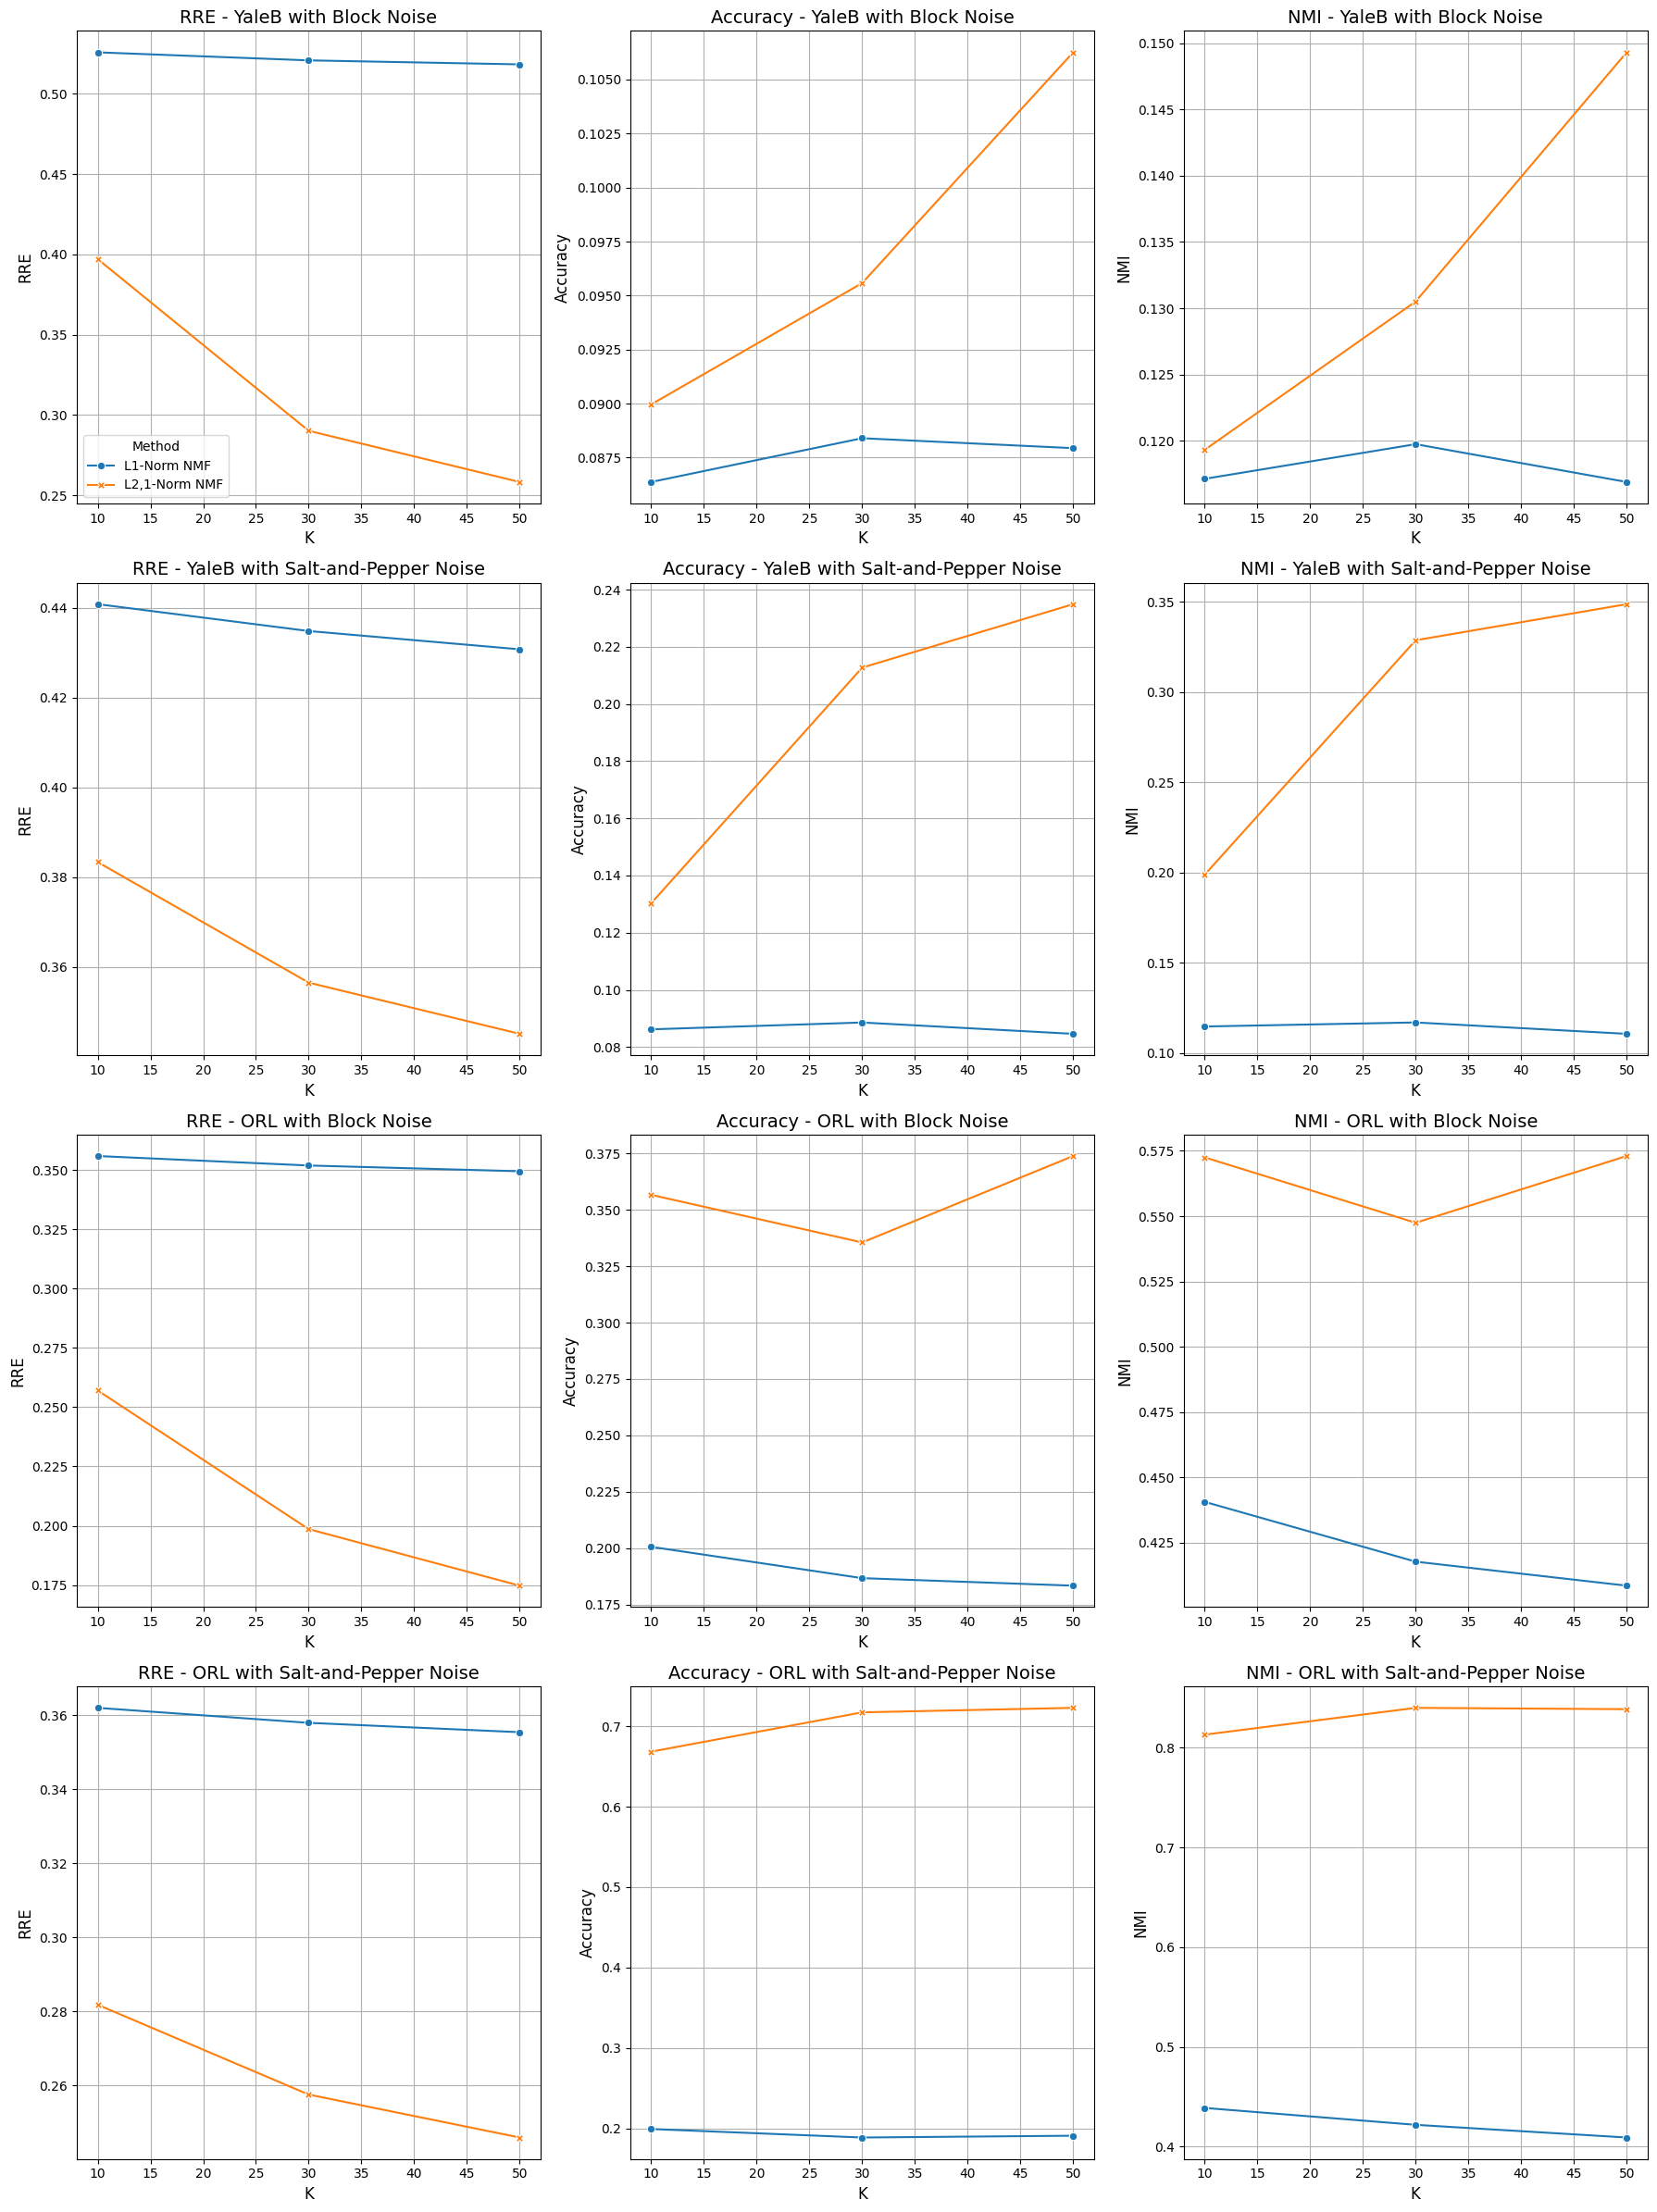

In [ ]:
# Plotting the metrics in a grid
plot_metrics_grid(df_all_stats)

*Visual demonstration of the two noise tyoe*

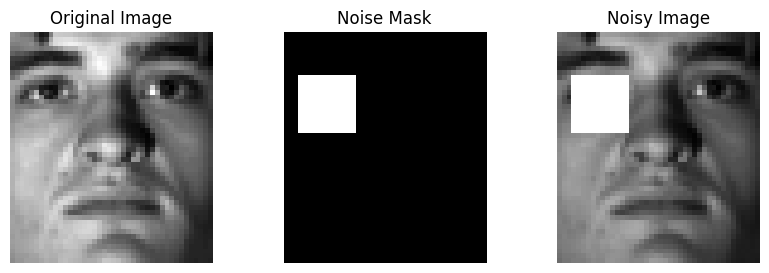

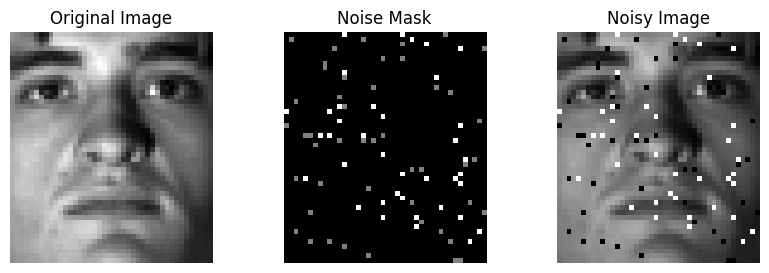

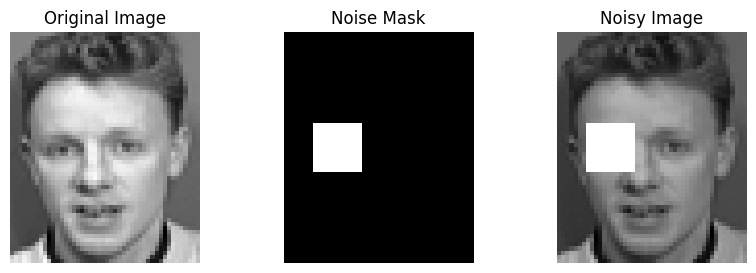

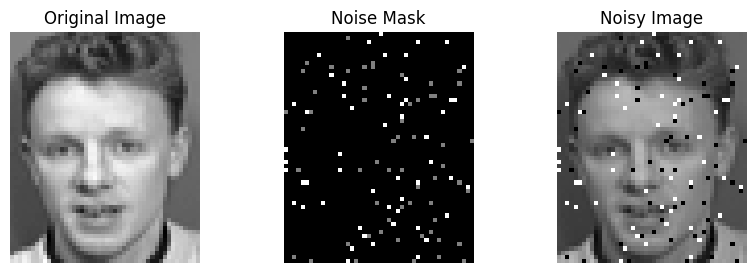

In [ ]:
# Visualize noise after all experiments
# Visualize block noise for YaleB dataset
if sample_images_yaleb_block:
    visualize_block_noise_fixed(
        sample_images_yaleb_block['X_original'],
        sample_images_yaleb_block['noise_mask'],
        sample_images_yaleb_block['X_noisy'],
        sample_images_yaleb_block['image_size']
    )

# Visualize salt-and-pepper noise for YaleB dataset
if sample_images_yaleb_sap:
    visualize_salt_and_pepper_noise(
        sample_images_yaleb_sap['X_original'],
        sample_images_yaleb_sap['noise_mask'],
        sample_images_yaleb_sap['X_noisy'],
        sample_images_yaleb_sap['image_size']
    )

# Visualize block noise for ORL dataset
if sample_images_orl_block:
    visualize_block_noise_fixed(
        sample_images_orl_block['X_original'],
        sample_images_orl_block['noise_mask'],
        sample_images_orl_block['X_noisy'],
        sample_images_orl_block['image_size']
    )

# Visualize salt-and-pepper noise for ORL dataset
if sample_images_orl_sap:
    visualize_salt_and_pepper_noise(
        sample_images_orl_sap['X_original'],
        sample_images_orl_sap['noise_mask'],
        sample_images_orl_sap['X_noisy'],
        sample_images_orl_sap['image_size']
    )
